# **Data Loading, EDA, Preprocessing, Feature engineering and Feature selection**

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

# !pip install category_encoders

In [2]:
df = pd.read_csv('/home/santosh/Desktop/MLOps/MLops-7-Project/notebook/data.csv',index_col=0)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [4]:
"""
need to check unique values before split data in categorical and numerical
because there are some features that seems numerical but they refer to a repetitive value that is identifier like policy channel
"""


for feature_names in df.columns:
    n_unique = df[feature_names].nunique()
    print(f"{feature_names}  ------->   {n_unique}")




Gender  ------->   2
Age  ------->   66
Driving_License  ------->   2
Region_Code  ------->   53
Previously_Insured  ------->   2
Vehicle_Age  ------->   3
Vehicle_Damage  ------->   2
Annual_Premium  ------->   48838
Policy_Sales_Channel  ------->   155
Vintage  ------->   290
Response  ------->   2


Response
0    334399
1     46710
Name: count, dtype: int64

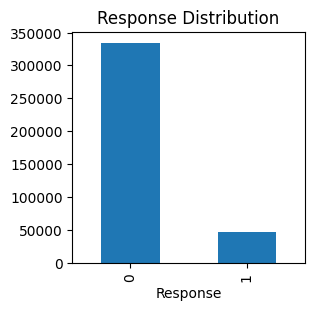

In [5]:
# target distribution
plt.figure(figsize=(3,3))

t1=df['Response'].value_counts()
t1.plot(kind='bar')
plt.title('Response Distribution')
t1


Text(0.5, 1.0, 'Age Distribution')

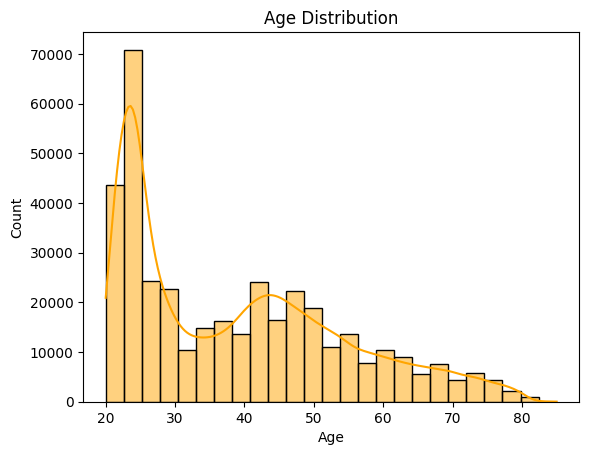

In [6]:
sns.histplot(df['Age'], bins=25, kde=True, color='orange')
plt.title('Age Distribution')

<Axes: xlabel='Gender', ylabel='count'>

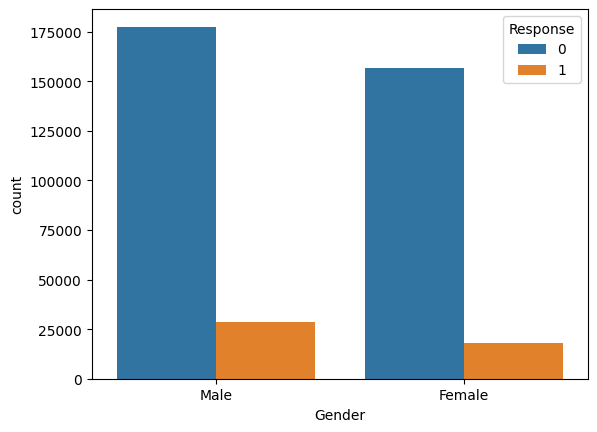

In [7]:
sns.countplot(data=df, x='Gender', hue='Response')

Text(0.5, 1.0, 'Gender vs Region code')

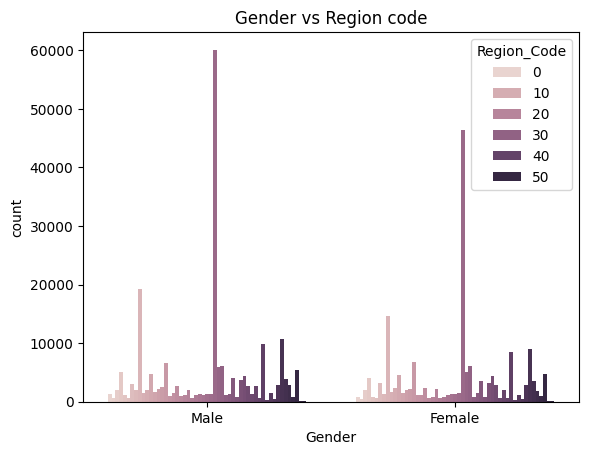

In [8]:
sns.countplot(hue='Region_Code', x='Gender', data=df)
plt.title('Gender vs Region code')

In [9]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## **Preprocessing**

In [10]:
X,y = df.iloc[:,:-1], df.iloc[:,-1]

In [11]:
Nans=dict(df.isna().sum(axis=0)/len(df))

for col,nan_percent in Nans.items():
    if nan_percent <=0.03:
        df[col]=df[col].ffill()
    elif nan_percent <=0.1:
        df[col].dropna(subset=[col], inplace=True)   #remove rows
    else:
        df.drop(columns=[col], inplace=True)   # remove the column

"pipeline note --->1"

'pipeline note --->1'

In [12]:
cats_features = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']
nums_features = [i for i in df.columns if i not in cats_features]

cats_df = df[cats_features]
nums_df = df[nums_features]

"pipeine note --->2"

'pipeine note --->2'

In [13]:
cats_df.head()

,Gender,Region_Code,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
id,,,,,
1,Male,28.0,> 2 Years,Yes,26.0
2,Male,3.0,1-2 Year,No,26.0
3,Male,28.0,> 2 Years,Yes,26.0
4,Male,11.0,< 1 Year,No,152.0
5,Female,41.0,< 1 Year,No,152.0


In [14]:
nums_df.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response
id,,,,,,
1,44,1,0,40454.0,217,1
2,76,1,0,33536.0,183,0
3,47,1,0,38294.0,27,1
4,21,1,1,28619.0,203,0
5,29,1,1,27496.0,39,0


In [15]:
# pipelines ---------> pipeline


high_cardinality_features = ['Region_Code','Policy_Sales_Channel']
low_cardinality_features = ['Gender','Vehicle_Age','Vehicle_Damage']
numerical_features = ['Age','Annual_Premium','Vintage']


cat_bost_pipeline = make_pipeline(ce.CatBoostEncoder(cols=high_cardinality_features))

oneHot_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False))
numerical_pipeline = make_pipeline(StandardScaler())


preprocessor = ColumnTransformer(
    transformers=[
        ('catboost',cat_bost_pipeline, high_cardinality_features),
        ('onehot',oneHot_pipeline,low_cardinality_features),
        ('numerial',numerical_pipeline,numerical_features)
    ],
    remainder='passthrough'
)

In [16]:
preprocessor.set_output(transform="pandas")
preprocessor.fit_transform(X,y)

,catboost__Region_Code,catboost__Policy_Sales_Channel,onehot__Gender_Female,onehot__Gender_Male,onehot__Vehicle_Age_1-2 Year,onehot__Vehicle_Age_< 1 Year,onehot__Vehicle_Age_> 2 Years,onehot__Vehicle_Damage_No,onehot__Vehicle_Damage_Yes,numerial__Age,numerial__Annual_Premium,numerial__Vintage,remainder__Driving_License,remainder__Previously_Insured
id,,,,,,,,,,,,,,
1,0.122563,0.122563,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.333777,0.574539,0.748795,1,0
2,0.122563,0.561282,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.396751,0.172636,0.342443,1,0
3,0.561282,0.374188,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.527181,0.449053,-1.521998,1,0
4,0.122563,0.122563,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.148985,-0.113018,0.581474,1,1
5,0.122563,0.061282,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.633242,-0.178259,-1.378580,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,0.072332,0.199389,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.267815,-0.022912,-0.792954,1,1
381106,0.079281,0.028624,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.568774,0.549093,-0.279037,1,1
381107,0.073835,0.021816,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.148985,0.264543,0.079509,1,1


## **final preprocessor func**


In [17]:
def preprocessor_func(df:pd.DataFrame) ->pd.DataFrame:
    X,y = df.iloc[:,:-1], df.iloc[:,-1]

    #handle Null values
    Nans=dict(X.isna().sum(axis=0)/len(X))
    for col,nan_percent in Nans.items():
        if nan_percent <=0.03:
            X[col]=X[col].ffill()
        elif nan_percent <=0.1:
            X[col].dropna(subset=[col], inplace=True)   #remove rows
        else:
            X.drop(columns=[col], inplace=True)   # remove the column
        

    #pipelenia

    high_cardinality_features = ['Region_Code','Policy_Sales_Channel']
    low_cardinality_features = ['Gender','Vehicle_Age','Vehicle_Damage']
    numerical_features = ['Age','Annual_Premium','Vintage']


    cat_bost_pipeline = make_pipeline(ce.CatBoostEncoder(cols=high_cardinality_features))

    oneHot_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    numerical_pipeline = make_pipeline(StandardScaler())


    preprocessor = ColumnTransformer(
        transformers=[
            ('catboost',cat_bost_pipeline, high_cardinality_features),
            ('onehot',oneHot_pipeline,low_cardinality_features),
            ('numerial',numerical_pipeline,numerical_features)
        ],
        remainder='passthrough'
    )
    preprocessor.set_output(transform="pandas")
    X= preprocessor.fit_transform(X,y)

    return X
    

In [ ]:
t=preprocessor_func(df)
# t[0].head(10)

KeyError: 0

In [19]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=6)

trainer = make_pipeline(preprocessor,RandomForestClassifier(min_samples_split=10,max_features=0.8,class_weight='balanced'))
trainer.fit(X_train,y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('catboost', ...), ('onehot', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
y_pred = trainer.predict(X_train)
y_pred_test = trainer.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94    267458
           1       0.62      0.46      0.53     37429

    accuracy                           0.90    304887
   macro avg       0.77      0.71      0.73    304887
weighted avg       0.89      0.90      0.89    304887



In [21]:
print(classification_report(y_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92     66941
           1       0.37      0.24      0.29      9281

    accuracy                           0.86     76222
   macro avg       0.64      0.59      0.61     76222
weighted avg       0.84      0.86      0.84     76222

